# Data Analysis & Split Strategy Rationale before finetuning

This notebook documents the data-driven decisions behind our dataset preparation pipeline.

**Key questions answered here:**
1. What does the annotation count distribution look like? (drives stratification strategy)
2. Why do standard percentile-based bins fail on this data?
3. How does empirical binning solve it?
4. Are the final train/val/test splits representative?
5. What do the bbox sizes and aspect ratios tell us about augmentation and model config?
6. What does the image resolution spread imply for `imgsz` choice?

In [1]:
import json
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)

TRAINING_ROOT = Path(".").resolve().parent
ANNOTATIONS = TRAINING_ROOT / "data" / "raw" / "annotations" / "_annotations.coco.json"
SPLITS_JSON = TRAINING_ROOT / "data" / "processed" / "splits.json"

with open(ANNOTATIONS) as f:
    coco = json.load(f)

print(f"Images: {len(coco['images'])}")
print(f"Annotations: {len(coco['annotations'])}")
print(f"Categories: {[c['name'] for c in coco['categories']]}")

Images: 191
Annotations: 521
Categories: ['Coin-Dataset', '0']


---
## 1. Object Count Distribution

The number of coins per image is the primary axis for stratification.
Let's look at the raw distribution before deciding on any binning strategy.

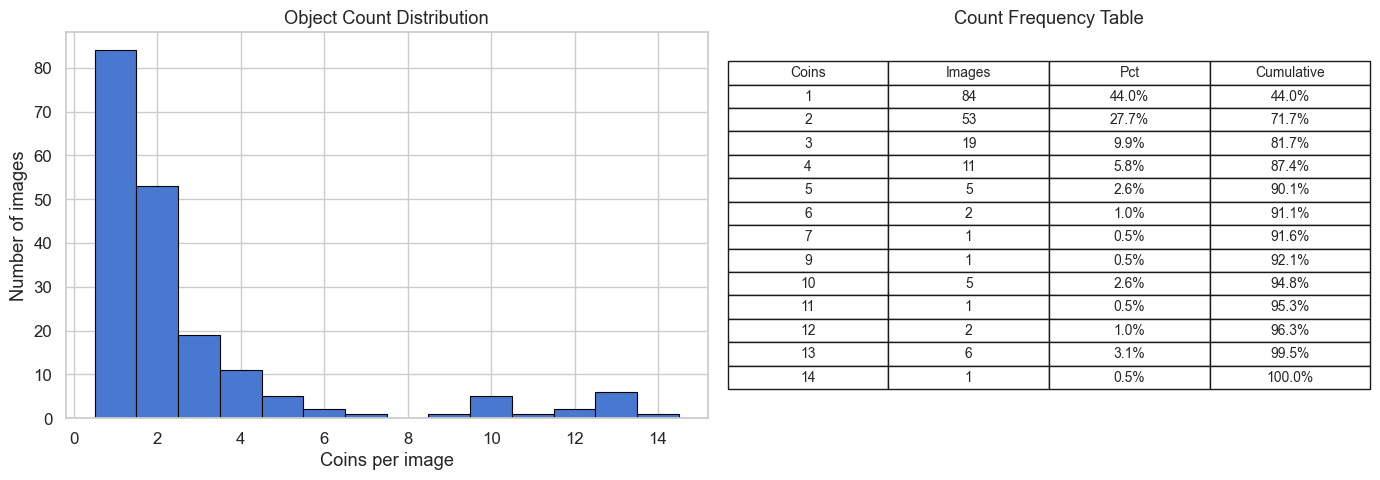


Key stats:
  Mean: 2.73
  Median: 2
  P25=1, P50=2, P75=3, P90=5
  Range: [1, 14]
  Skewness: 2.44


In [2]:
# Count annotations per image
ann_counts = defaultdict(int)
for ann in coco["annotations"]:
    ann_counts[ann["image_id"]] += 1

# Include images with 0 annotations if any
for img in coco["images"]:
    if img["id"] not in ann_counts:
        ann_counts[img["id"]] = 0

counts = np.array(sorted(ann_counts.values()))
count_dist = Counter(counts.tolist())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax = axes[0]
bins_range = range(min(counts), max(counts) + 2)
ax.hist(counts, bins=[b - 0.5 for b in bins_range], edgecolor="black", linewidth=0.8)
ax.set_xlabel("Coins per image")
ax.set_ylabel("Number of images")
ax.set_title("Object Count Distribution")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Table view
ax = axes[1]
ax.axis("off")
table_data = []
cumulative = 0
for k in sorted(count_dist.keys()):
    pct = count_dist[k] / len(counts) * 100
    cumulative += pct
    table_data.append([k, count_dist[k], f"{pct:.1f}%", f"{cumulative:.1f}%"])

table = ax.table(
    cellText=table_data,
    colLabels=["Coins", "Images", "Pct", "Cumulative"],
    loc="center",
    cellLoc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.4)
ax.set_title("Count Frequency Table")

plt.tight_layout()
plt.show()

print(f"\nKey stats:")
print(f"  Mean: {np.mean(counts):.2f}")
print(f"  Median: {np.median(counts):.0f}")
print(f"  P25={np.percentile(counts, 25):.0f}, P50={np.percentile(counts, 50):.0f}, "
      f"P75={np.percentile(counts, 75):.0f}, P90={np.percentile(counts, 90):.0f}")
print(f"  Range: [{min(counts)}, {max(counts)}]")
print(f"  Skewness: {float(((counts - counts.mean()) ** 3).mean() / counts.std() ** 3):.2f}")

### Observations

The distribution is **heavily right-skewed**:
- 44% of images have exactly 1 coin, 72% have 1-2 coins
- A long tail stretches from 4 to 14 coins, with gaps (no images with 8 coins)
- The tail contains 24 images with very different scene characteristics (crowded, overlapping)

This skew is the root cause of all the stratification complexity below.

---
## 2. Why Fixed Bins Fail

A naive approach bins images as `(1, 2, 3, 4+)`. Let's see what happens.

In [3]:
# Fixed binning: min(count, 4)
fixed_bins = defaultdict(list)
for img_id, count in ann_counts.items():
    fixed_bins[min(count, 4)].append(img_id)

print("Fixed bins (1, 2, 3, 4+):")
print(f"{'Bin':<8} {'Images':<10} {'Pct':<8} {'Unique counts collapsed'}")
print("-" * 60)
for bin_key in sorted(fixed_bins.keys()):
    ids = fixed_bins[bin_key]
    pct = len(ids) / len(ann_counts) * 100
    if bin_key == 4:
        collapsed = sorted(set(ann_counts[i] for i in ids))
        print(f"{bin_key:<8} {len(ids):<10} {pct:>5.1f}%   {collapsed}")
    else:
        print(f"{bin_key:<8} {len(ids):<10} {pct:>5.1f}%   [{bin_key}]")

Fixed bins (1, 2, 3, 4+):
Bin      Images     Pct      Unique counts collapsed
------------------------------------------------------------
1        84          44.0%   [1]
2        53          27.7%   [2]
3        19           9.9%   [3]
4        35          18.3%   [4, 5, 6, 7, 9, 10, 11, 12, 13, 14]


**Problem:** The `4+` bin collapses counts 4 through 14 into a single bucket.
Images with 4 coins (simple scene) and 13 coins (densely packed) have fundamentally different
detection challenges, yet the stratifier treats them identically.

This means:
- A random 15% from the 4+ bin could get all the easy (4-coin) images, leaving the hard cases in train only
- Or vice versa, the test set could over-represent crowded scenes
- Either way, the test set is not representative of the tail

---
## 3. Why Percentile-Based Bins Also Fail

A common alternative: use quartile/quintile boundaries from the data.
Let's see if that works.

In [4]:
print("Percentile-based bin edges:")
print()
for n_quantiles, label in [(4, "Quartiles"), (5, "Quintiles"), (10, "Deciles")]:
    edges = np.percentile(counts, np.linspace(0, 100, n_quantiles + 1)[1:-1])
    unique_edges = np.unique(edges)
    print(f"  {label} ({n_quantiles} bins):")
    print(f"    Raw edges: {edges}")
    print(f"    Unique edges: {unique_edges}")
    print(f"    Effective bins: {len(unique_edges) + 1}")
    print()

Percentile-based bin edges:

  Quartiles (4 bins):
    Raw edges: [1. 2. 3.]
    Unique edges: [1. 2. 3.]
    Effective bins: 4

  Quintiles (5 bins):
    Raw edges: [1. 1. 2. 3.]
    Unique edges: [1. 2. 3.]
    Effective bins: 4

  Deciles (10 bins):
    Raw edges: [1. 1. 1. 1. 2. 2. 2. 3. 5.]
    Unique edges: [1. 2. 3. 5.]
    Effective bins: 5



**Result:** Percentile edges collapse to `[1, 2, 3]` regardless of whether we use quartiles, quintiles, or deciles.

This happens because the data is **discrete and heavily concentrated** at low values:
- P25 = 1, P50 = 2, P75 = 3
- Even P90 = 5

With `np.digitize`, this produces effectively the same 4 bins as the fixed approach, failing to separate the tail.

**Conclusion:** Neither fixed thresholds nor percentile-based edges work on discrete, skewed count data.

---
## 4. Empirical Binning: The Data-Driven Solution

Instead of imposing external thresholds, let the data define the bins:
- Each annotation count that appears in **>= `min_bin_size` images** becomes its own stratum
- Sparse counts (< `min_bin_size`) are merged into a `tail` bin

This adapts to whatever distribution we have.

In [5]:
MIN_BIN_SIZE = 3  # need >= 3 images to split meaningfully into train/val/test

count_freq = Counter(ann_counts.values())

standalone = {k for k, freq in count_freq.items() if freq >= MIN_BIN_SIZE}
tail_counts = {k for k, freq in count_freq.items() if freq < MIN_BIN_SIZE}

print(f"min_bin_size = {MIN_BIN_SIZE}")
print(f"\nStandalone strata (each count is its own bin):")
for k in sorted(standalone):
    print(f"  count={k}: {count_freq[k]} images")

print(f"\nMerged into tail ({len(tail_counts)} distinct counts, {sum(count_freq[k] for k in tail_counts)} images):")
for k in sorted(tail_counts):
    print(f"  count={k}: {count_freq[k]} images")

min_bin_size = 3

Standalone strata (each count is its own bin):
  count=1: 84 images
  count=2: 53 images
  count=3: 19 images
  count=4: 11 images
  count=5: 5 images
  count=10: 5 images
  count=13: 6 images

Merged into tail (6 distinct counts, 8 images):
  count=6: 2 images
  count=7: 1 images
  count=9: 1 images
  count=11: 1 images
  count=12: 2 images
  count=14: 1 images


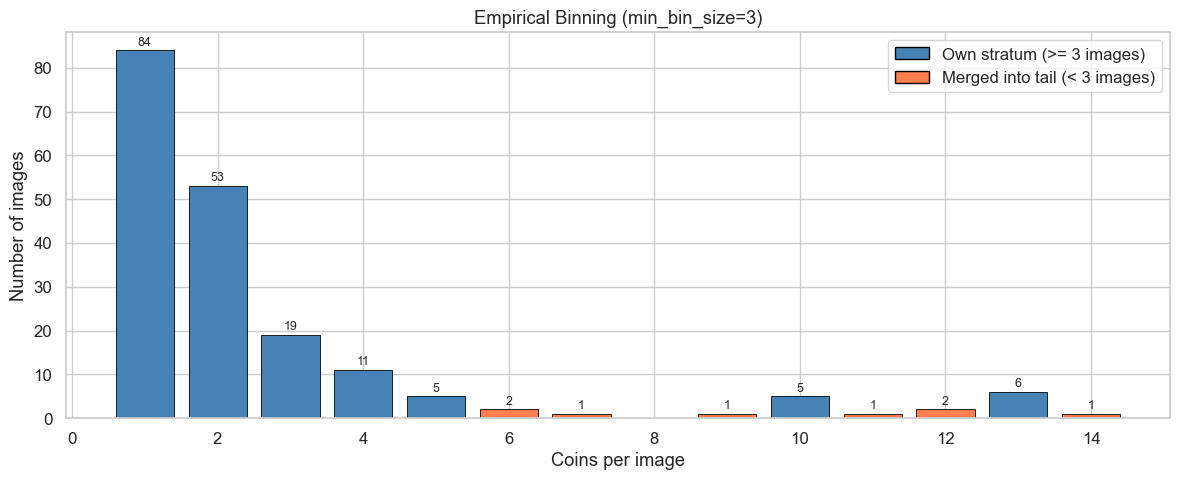

In [6]:
# Visualize the binning
fig, ax = plt.subplots(figsize=(12, 5))

all_count_vals = sorted(count_freq.keys())
colors = ["steelblue" if c in standalone else "coral" for c in all_count_vals]
freqs = [count_freq[c] for c in all_count_vals]

bars = ax.bar(all_count_vals, freqs, color=colors, edgecolor="black", linewidth=0.6)

# Add count labels on bars
for bar, freq in zip(bars, freqs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            str(freq), ha="center", va="bottom", fontsize=9)

ax.set_xlabel("Coins per image")
ax.set_ylabel("Number of images")
ax.set_title(f"Empirical Binning (min_bin_size={MIN_BIN_SIZE})")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="steelblue", edgecolor="black", label=f"Own stratum (>= {MIN_BIN_SIZE} images)"),
    Patch(facecolor="coral", edgecolor="black", label=f"Merged into tail (< {MIN_BIN_SIZE} images)"),
]
ax.legend(handles=legend_elements, loc="upper right")

plt.tight_layout()
plt.show()

**Why `min_bin_size=3`?**

We need at least 1 image in each of train, val, and test from every bin (the split function uses `max(1, int(n * ratio))`).
With 3 images we get a 1/1/1 split; with fewer, the bin would be entirely consumed by test+val, leaving nothing for training.

The tail bin (8 images) merges counts 6, 7, 9, 11, 12, 14 — all are rare edge cases that share the property of being
"uncommon high-count scenes". Grouping them ensures each split gets at least one.

---
## 5. Split Validation

Let's verify the actual train/val/test split produced by `prepare_dataset.py` is representative.

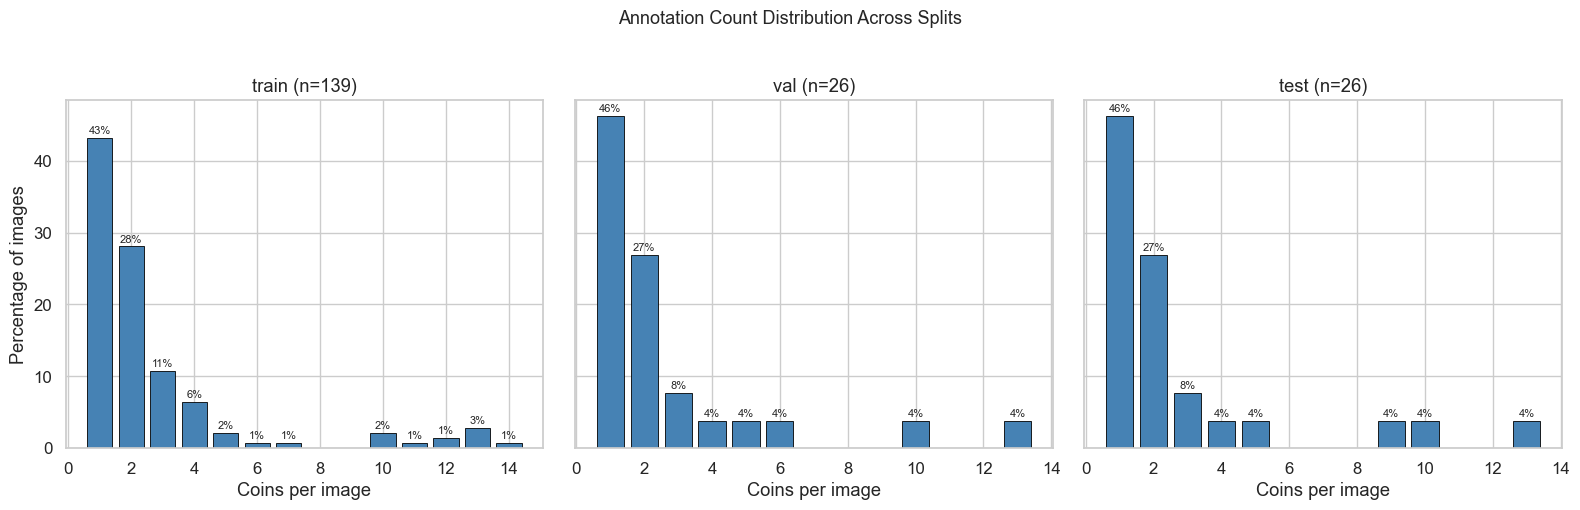

In [7]:
with open(SPLITS_JSON) as f:
    splits = json.load(f)

# Per-split count distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for ax, split_name in zip(axes, ["train", "val", "test"]):
    split_counts = [e["num_annotations"] for e in splits[split_name]]
    split_dist = Counter(split_counts)
    n = len(split_counts)

    vals = sorted(split_dist.keys())
    freqs = [split_dist[v] for v in vals]
    pcts = [split_dist[v] / n * 100 for v in vals]

    bars = ax.bar(vals, pcts, color="steelblue", edgecolor="black", linewidth=0.6)
    ax.set_title(f"{split_name} (n={n})")
    ax.set_xlabel("Coins per image")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    for bar, pct in zip(bars, pcts):
        if pct > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                    f"{pct:.0f}%", ha="center", va="bottom", fontsize=8)

axes[0].set_ylabel("Percentage of images")
plt.suptitle("Annotation Count Distribution Across Splits", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

In [8]:
# Summary statistics comparison
print(f"{'Split':<8} {'N':<6} {'Anns':<8} {'Mean':<8} {'Median':<8} {'Std':<8} {'Range'}")
print("-" * 65)
for split_name in ("train", "val", "test"):
    split_counts = np.array([e["num_annotations"] for e in splits[split_name]])
    total_anns = split_counts.sum()
    print(f"{split_name:<8} {len(split_counts):<6} {total_anns:<8} {split_counts.mean():<8.2f} "
          f"{np.median(split_counts):<8.0f} {split_counts.std():<8.2f} [{split_counts.min()}, {split_counts.max()}]")

print(f"\nSeed: {splits['seed']}, Val ratio: {splits['val_ratio']}, Test ratio: {splits['test_ratio']}")

Split    N      Anns     Mean     Median   Std      Range
-----------------------------------------------------------------
train    139    378      2.72     2        2.95     [1, 14]
val      26     70       2.69     2        2.88     [1, 13]
test     26     73       2.81     2        3.06     [1, 13]

Seed: 42, Val ratio: 0.15, Test ratio: 0.15


### Split Quality Check

Look for:
- **Similar means** across splits (validates proportional sampling)
- **Test set covers the tail** (has images with high coin counts)
- **No split is pathologically easy or hard** (range is comparable)

---
## 6. Bounding Box Size & Aspect Ratio Analysis

These distributions inform augmentation and model architecture decisions.

In [11]:
img_lookup = {img["id"]: img for img in coco["images"]}

bbox_widths = []
bbox_heights = []
aspect_ratios = []
rel_areas = []  # bbox_area / image_area

for ann in coco["annotations"]:
    _, _, w, h = ann["bbox"]
    bbox_widths.append(w)
    bbox_heights.append(h)
    aspect_ratios.append(w / h if h > 0 else 0)

    img = img_lookup[ann["image_id"]]
    rel_areas.append(ann["area"] / (img["width"] * img["height"]))

bbox_widths = np.array(bbox_widths)
bbox_heights = np.array(bbox_heights)
aspect_ratios = np.array(aspect_ratios)
rel_areas = np.array(rel_areas)

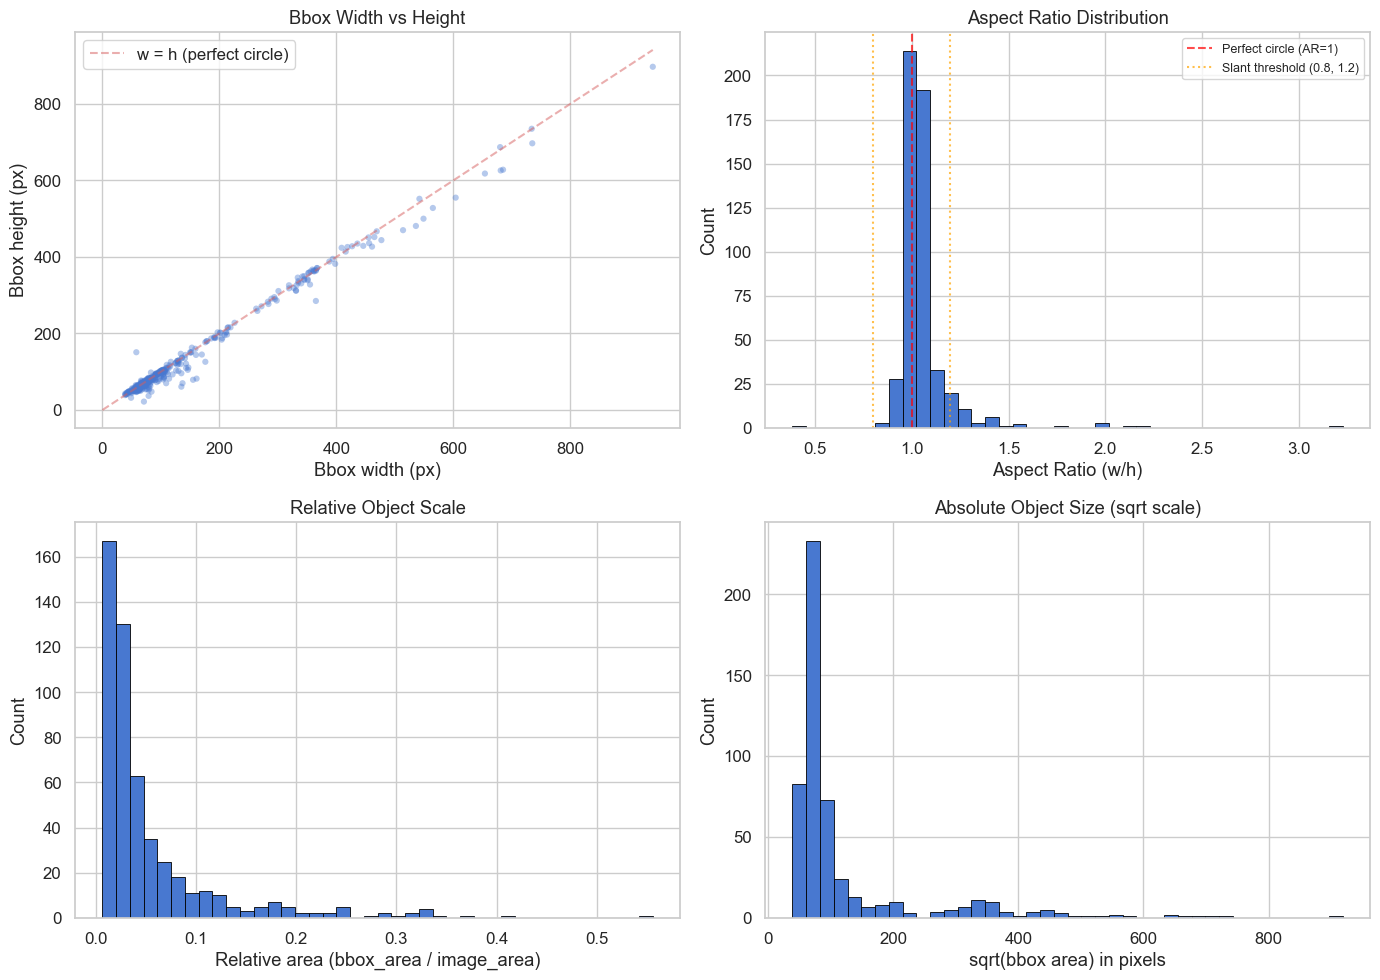

Aspect ratio stats:
  Mean: 1.06, Std: 0.17
  Slanted (AR outside [0.8, 1.2]): 41/521 (7.9%)

Relative area stats:
  Mean: 0.0556, Median: 0.0303
  Range: [0.0066, 0.5559]


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Bbox width vs height
ax = axes[0, 0]
ax.scatter(bbox_widths, bbox_heights, alpha=0.4, s=20, edgecolors="none")
max_dim = max(bbox_widths.max(), bbox_heights.max())
ax.plot([0, max_dim], [0, max_dim], "r--", alpha=0.5, label="w = h (perfect circle)")
ax.set_xlabel("Bbox width (px)")
ax.set_ylabel("Bbox height (px)")
ax.set_title("Bbox Width vs Height")
ax.legend()

# Aspect ratio distribution
ax = axes[0, 1]
ax.hist(aspect_ratios, bins=40, edgecolor="black", linewidth=0.6)
ax.axvline(1.0, color="red", linestyle="--", alpha=0.7, label="Perfect circle (AR=1)")
ax.axvline(0.8, color="orange", linestyle=":", alpha=0.7, label="Slant threshold (0.8, 1.2)")
ax.axvline(1.2, color="orange", linestyle=":", alpha=0.7)
ax.set_xlabel("Aspect Ratio (w/h)")
ax.set_ylabel("Count")
ax.set_title("Aspect Ratio Distribution")
ax.legend(fontsize=9)

# Relative bbox area
ax = axes[1, 0]
ax.hist(rel_areas, bins=40, edgecolor="black", linewidth=0.6)
ax.set_xlabel("Relative area (bbox_area / image_area)")
ax.set_ylabel("Count")
ax.set_title("Relative Object Scale")

# Absolute bbox area (sqrt for interpretability)
ax = axes[1, 1]
areas_sqrt = np.sqrt(bbox_widths * bbox_heights)
ax.hist(areas_sqrt, bins=40, edgecolor="black", linewidth=0.6)
ax.set_xlabel("sqrt(bbox area) in pixels")
ax.set_ylabel("Count")
ax.set_title("Absolute Object Size (sqrt scale)")

plt.tight_layout()
plt.show()

# Stats
n_slanted = np.sum((aspect_ratios < 0.8) | (aspect_ratios > 1.2))
print(f"Aspect ratio stats:")
print(f"  Mean: {aspect_ratios.mean():.2f}, Std: {aspect_ratios.std():.2f}")
print(f"  Slanted (AR outside [0.8, 1.2]): {n_slanted}/{len(aspect_ratios)} ({n_slanted/len(aspect_ratios)*100:.1f}%)")
print(f"\nRelative area stats:")
print(f"  Mean: {rel_areas.mean():.4f}, Median: {np.median(rel_areas):.4f}")
print(f"  Range: [{rel_areas.min():.4f}, {rel_areas.max():.4f}]")

### Augmentation Implications

| Observation | Implication | Config choice |
|---|---|---|
| ~90% coins are near-circular (AR 0.8-1.2) | Rotation augmentation is safe, won't distort circles into implausible shapes | `degrees: 15.0` |
| ~10% are slanted (viewpoint distortion) | Moderate scale augmentation helps learn perspective invariance | `scale: 0.5` |
| Bbox sizes span 39px to 941px | Large scale variance — mosaic helps see multiple scales | `mosaic: 1.0` |
| Relative area mean ~5.6% | Objects are moderate-sized relative to image — standard YOLOv8 anchor-free design handles this well | `imgsz: 640` |
| No flipping asymmetry (coins are symmetric) | Horizontal flip is safe | `fliplr: 0.5` |

---
## 7. Image Resolution Spread

Understanding the resolution distribution helps validate `imgsz=640` as the training input size.

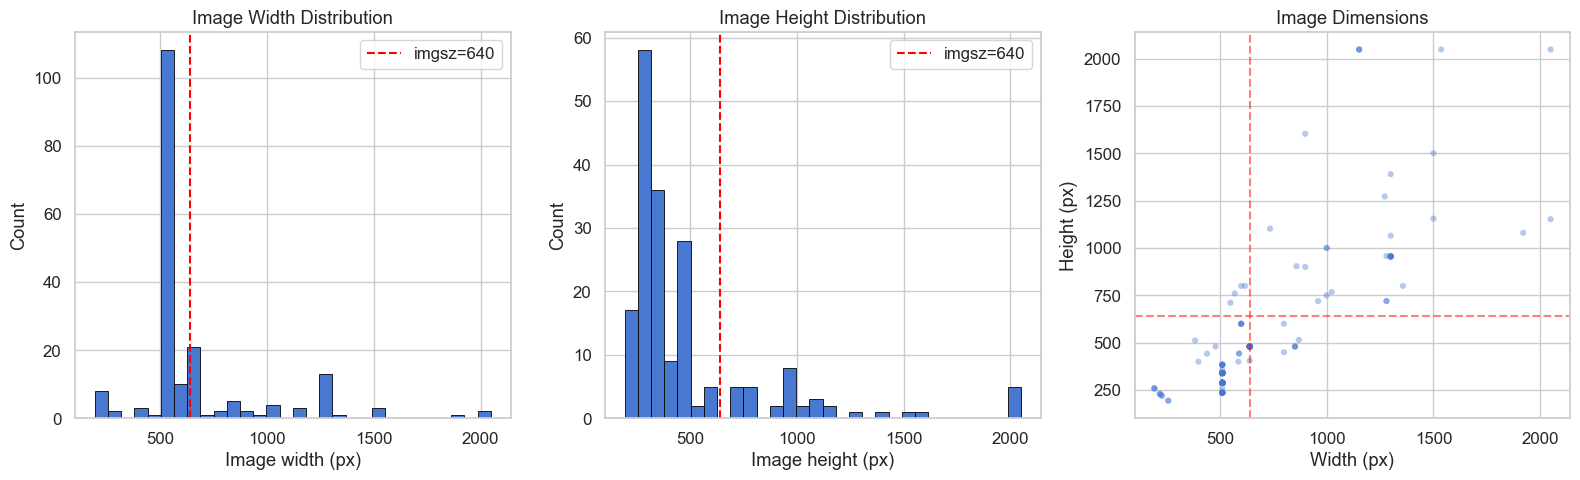

Image resolution stats:
  Widths:  range=[194, 2048], median=512
  Heights: range=[194, 2048], median=340
  Both dims <= 640: 78.0% of images
  At least one dim > 640: 22.0% of images


In [13]:
img_widths = np.array([img["width"] for img in coco["images"]])
img_heights = np.array([img["height"] for img in coco["images"]])
img_areas = img_widths * img_heights

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Width distribution
ax = axes[0]
ax.hist(img_widths, bins=30, edgecolor="black", linewidth=0.6)
ax.axvline(640, color="red", linestyle="--", label="imgsz=640")
ax.set_xlabel("Image width (px)")
ax.set_ylabel("Count")
ax.set_title("Image Width Distribution")
ax.legend()

# Height distribution
ax = axes[1]
ax.hist(img_heights, bins=30, edgecolor="black", linewidth=0.6)
ax.axvline(640, color="red", linestyle="--", label="imgsz=640")
ax.set_xlabel("Image height (px)")
ax.set_ylabel("Count")
ax.set_title("Image Height Distribution")
ax.legend()

# Scatter of w vs h
ax = axes[2]
ax.scatter(img_widths, img_heights, alpha=0.4, s=20, edgecolors="none")
ax.axvline(640, color="red", linestyle="--", alpha=0.5)
ax.axhline(640, color="red", linestyle="--", alpha=0.5)
ax.set_xlabel("Width (px)")
ax.set_ylabel("Height (px)")
ax.set_title("Image Dimensions")

plt.tight_layout()
plt.show()

pct_below_640 = np.sum((img_widths <= 640) & (img_heights <= 640)) / len(img_widths) * 100
pct_above_640 = np.sum((img_widths > 640) | (img_heights > 640)) / len(img_widths) * 100

print(f"Image resolution stats:")
print(f"  Widths:  range=[{img_widths.min()}, {img_widths.max()}], median={np.median(img_widths):.0f}")
print(f"  Heights: range=[{img_heights.min()}, {img_heights.max()}], median={np.median(img_heights):.0f}")
print(f"  Both dims <= 640: {pct_below_640:.1f}% of images")
print(f"  At least one dim > 640: {pct_above_640:.1f}% of images")

### `imgsz` Decision

The images range from 194x194 to 2048x2048. Using `imgsz=640` means:
- **Small images (< 640)** get upscaled — coins become larger, potentially easier to detect
- **Large images (> 640)** get downscaled — some fine detail is lost but coins are still well-represented given their relative area (~5.6% on average)

640 is the YOLOv8 default and a good balance between detail preservation and training speed.
Going to 1024 would help on the large images but would 4x the memory cost — not justified given the small dataset size.

---
## 8. Annotation Quality Sanity Checks

Quick checks for potential data quality issues before training.

In [14]:
issues = []

for ann in coco["annotations"]:
    img = img_lookup[ann["image_id"]]
    x, y, w, h = ann["bbox"]

    # Check: bbox within image bounds
    if x < 0 or y < 0 or x + w > img["width"] + 1 or y + h > img["height"] + 1:
        issues.append(("out_of_bounds", ann["id"], img["file_name"]))

    # Check: degenerate bbox (zero or near-zero area)
    if w < 5 or h < 5:
        issues.append(("tiny_bbox", ann["id"], img["file_name"], f"{w}x{h}"))

    # Check: extreme aspect ratio (> 3:1 or < 1:3)
    ar = w / h if h > 0 else float("inf")
    if ar > 3 or ar < 1/3:
        issues.append(("extreme_aspect_ratio", ann["id"], img["file_name"], f"AR={ar:.2f}"))

if issues:
    print(f"Found {len(issues)} potential issues:")
    for issue in issues:
        print(f"  {issue}")
else:
    print("No annotation quality issues found.")

# Check for duplicate annotations (same image, very similar bbox)
from itertools import combinations

def iou(b1, b2):
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2
    xa = max(x1, x2)
    ya = max(y1, y2)
    xb = min(x1+w1, x2+w2)
    yb = min(y1+h1, y2+h2)
    inter = max(0, xb-xa) * max(0, yb-ya)
    union = w1*h1 + w2*h2 - inter
    return inter / union if union > 0 else 0

img_anns_grouped = defaultdict(list)
for ann in coco["annotations"]:
    img_anns_grouped[ann["image_id"]].append(ann)

n_near_dupes = 0
for img_id, anns in img_anns_grouped.items():
    for a1, a2 in combinations(anns, 2):
        if iou(a1["bbox"], a2["bbox"]) > 0.9:
            n_near_dupes += 1
            if n_near_dupes <= 3:
                print(f"  Near-duplicate: ann {a1['id']} & {a2['id']} in {img_lookup[img_id]['file_name']} "
                      f"(IoU={iou(a1['bbox'], a2['bbox']):.3f})")

print(f"\nNear-duplicate annotations (IoU > 0.9): {n_near_dupes}")

Found 1 potential issues:
  ('extreme_aspect_ratio', 84, 'DSC_0357_jpg.rf.2d50504e8a54ce3b58b9d75c26cb6378.jpg', 'AR=3.23')
  Near-duplicate: ann 439 & 440 in 939bf6b9-f5dc-4025-8ece-845bf3ae5544_jpg.rf.cb77f4b8751e317e80c98f7820a1b5aa.jpg (IoU=0.979)

Near-duplicate annotations (IoU > 0.9): 1


---
## 9. COCO to YOLO Conversion Validation

Spot-check that the COCO-to-YOLO bbox conversion produces correct normalized coordinates.

In [15]:
# Pick a few annotations and verify the conversion
print(f"{'Ann ID':<8} {'Image':<12} {'COCO [x,y,w,h]':<24} {'YOLO [cx,cy,w,h]':<36} {'Back-converted [x,y,w,h]':<30} {'Match'}")
print("-" * 120)

for ann in coco["annotations"][:8]:
    img = img_lookup[ann["image_id"]]
    x, y, w, h = ann["bbox"]
    iw, ih = img["width"], img["height"]

    # Forward: COCO -> YOLO
    cx = (x + w/2) / iw
    cy = (y + h/2) / ih
    nw = w / iw
    nh = h / ih

    # Backward: YOLO -> COCO (for verification)
    bx = (cx - nw/2) * iw
    by = (cy - nh/2) * ih
    bw = nw * iw
    bh = nh * ih

    match = abs(bx-x) < 0.01 and abs(by-y) < 0.01 and abs(bw-w) < 0.01 and abs(bh-h) < 0.01

    print(f"{ann['id']:<8} {img['id']:<12} [{x:.1f}, {y:.1f}, {w:.1f}, {h:.1f}]{'':<6} "
          f"[{cx:.6f}, {cy:.6f}, {nw:.6f}, {nh:.6f}]{'':<4} "
          f"[{bx:.1f}, {by:.1f}, {bw:.1f}, {bh:.1f}]{'':<8} {'OK' if match else 'FAIL'}")

Ann ID   Image        COCO [x,y,w,h]           YOLO [cx,cy,w,h]                     Back-converted [x,y,w,h]       Match
------------------------------------------------------------------------------------------------------------------------
0        0            [67.0, 83.0, 72.0, 71.0]       [0.530928, 0.457529, 0.371134, 0.274131]     [67.0, 83.0, 72.0, 71.0]         OK
1        1            [185.0, 75.0, 86.0, 86.0]       [0.445312, 0.500000, 0.167969, 0.364407]     [185.0, 75.0, 86.0, 86.0]         OK
2        2            [85.0, 65.0, 365.0, 285.0]       [0.417969, 0.432292, 0.570312, 0.593750]     [85.0, 65.0, 365.0, 285.0]         OK
3        3            [521.0, 201.0, 680.0, 687.0]       [0.448437, 0.504167, 0.354167, 0.636111]     [521.0, 201.0, 680.0, 687.0]         OK
4        4            [199.0, 164.0, 50.0, 47.0]       [0.437500, 0.551471, 0.097656, 0.138235]     [199.0, 164.0, 50.0, 47.0]         OK
5        4            [264.0, 141.0, 50.0, 44.0]       [0.564453, 0.47

---
## Summary of Decisions

| Decision | Rationale | Evidence |
|---|---|---|
| **3-way split** (train/val/test) | Val is used for checkpoint selection, so we need a separate held-out test for unbiased reporting | Standard ML practice |
| **Empirical binning** for stratification | Percentile bins collapse on this skewed discrete distribution; fixed bins hide tail diversity | Sections 2-4 above |
| **`min_bin_size=3`** | Minimum needed to populate all 3 splits from each bin | Arithmetic: need >= 1 per split |
| **`imgsz=640`** | Good balance: images range 194-2048px, 640 is median neighborhood, avoids 4x memory cost of 1024 | Section 7 |
| **`degrees=15`** rotation | 90% of coins are near-circular, rotation is safe; 15 degrees avoids unrealistic orientations for backgrounds | Section 6 |
| **`mosaic=1.0`** | Large variation in object count (1-14) and size (39-941px) — mosaic exposes model to multi-scale, multi-count scenes | Section 6 |
| **`fliplr=0.5`, `flipud=0.0`** | Coins are horizontally symmetric; vertical flip could create unnatural backgrounds (text upside down, etc.) | Domain knowledge |
| **`mixup=0.1`** | Light mixup adds regularization without distorting coin edges too much | Conservative default |